# Proyecto 2.2.  EDA con limpieza
## Bogdan Kaleb García Rivera

El objetivo de este proyecto es realizar la limpieza del conjunto de datos del EDA de música adquirido con webscraping a través de la plataforma Genius.com, además de realizar la comparación con respecto al mismo conjunto pero sin limpieza. 


Importar el conjunto de datos

In [149]:
import pandas as pd

df = pd.read_json('./songs_fixed.json')
print("Columnas del dataset: ",df.columns)
df.head()

Columnas del dataset:  Index(['song_name', 'artist_name', 'album_name', 'lyrics', 'release_date',
       'producers', 'tags'],
      dtype='object')


,song_name,artist_name,album_name,lyrics,release_date,producers,tags
0,ІНТЕРСІТІ (Intercity),NORD DIVISION,АЗАРТ - EP,1 Contributor\nІНТЕРСІТІ (Intercity) Lyrics\nЗ...,"March 1, 2025",[],"[Rap, Українською (In Ukrainian), Український ..."
1,Ya ya,Hurriganes,Jailbird,1 Contributor\nYa ya Lyrics\nSitting in the la...,None,[],[Pop]
2,#ДЕНЬГИБЛЯНУЖНЫМНЕ (#INEEDTHEFUCKINGMONEY),huzzy b,None,3 Contributors\n#ДЕНЬГИБЛЯНУЖНЫМНЕ (#INEEDTHEF...,"August 23, 2024",[],"[Rap, Trap, Русский трэп (Russian Trap), Русск..."
3,МАРЕВО (MIRAGE),FCK FAMOUS GROUP,"ХОРОШИЙ ПОГАНИЙ ЗЛИЙ (THE GOOD, THE BAD AND TH...",1 Contributor\nМАРЕВО (MIRAGE) Lyrics\nЯкий же...,"February 14, 2025",[],"[Rap, Український реп (Ukrainian Rap), Україна..."
4,Seni Kaybettim,Feridun Düzağaç,None,"1 Contributor\nSeni Kaybettim Lyrics\n[""Seni K...","August 2, 2024",[],"[Pop, Türkçe Pop, Türkçe, Türkiye]"


Para utilizar la librería NLTK se necesitan realizar ajustes adicionales

In [150]:
import nltk
from nltk.tokenize import word_tokenize
import os

ruta_descarga = os.path.join(os.getcwd(), 'nltk_data') # Descargar en el directorio actual
nltk.download('punkt_tab', download_dir=ruta_descarga)

# Agregar la ruta de descarga a las rutas de búsqueda de NLTK
nltk.data.path.append(ruta_descarga)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\bugy1\OneDrive\Escritorio\eda_raw_v2\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt_tab is already up-to-date!


1. Determinar que puede considerarse como  ruido e implementar el conteo de ruido

En este análisis, solo se tomarán en cuenta canciones cuyas letras estén escritas exclusivamente con caracteres alfanuméricos. Cualquier elemento de otros sistemas de escritura (como chino mandarín o japonés) se considerará ruido y se omitirá. De manera similar, se tratarán como ruido los símbolos de puntuación, los caracteres de escape, los símbolos musicales o artísticos, así como elementos HTML y marcas de tiempo (como '[13:55]'). El análisis se centrará principalmente en la columna 'lyrics'. 

In [ ]:
import pandas as pd
import re

def calcular_ruido(texto, patron):
    if not isinstance(texto, str) or len(texto) == 0:
        return 0
    caracteres_ruido = len(re.sub(patron, '', texto))
    return (caracteres_ruido / len(texto)) * 100

patron_permitido = re.compile(
    r'[a-zA-ZáéíóúÁÉÍÓÚàèìòùÀÈÌÒÙäëïöüÄËÏÖÜâêîôûÂÊÎÔÛñÑçÇ\s\[\]]', #Caracteres alfanuméricos y corchetes no vacíos
    re.UNICODE
)


df['porcentaje_ruido'] = df['lyrics'].apply(calcular_ruido, args=(patron_permitido,))

porcentaje_ruido_total = df['porcentaje_ruido'].mean()

print(f"Porcentaje de ruido total (promedio): {porcentaje_ruido_total:.2f}%")
print("\nPrimeras filas con porcentaje de ruido:")
df[['song_name', 'artist_name', 'porcentaje_ruido']].head()

Porcentaje de ruido total (promedio): 14.00%

Primeras filas con su porcentaje:


,song_name,artist_name,porcentaje_ruido
0,ІНТЕРСІТІ (Intercity),NORD DIVISION,81.675593
1,Ya ya,Hurriganes,3.112840
2,#ДЕНЬГИБЛЯНУЖНЫМНЕ (#INEEDTHEFUCKINGMONEY),huzzy b,70.614035
3,МАРЕВО (MIRAGE),FCK FAMOUS GROUP,80.612245
4,Seni Kaybettim,Feridun Düzağaç,6.878762


2. Eliminar el ruido y contar el ruido final (recuerda que no debe ser 0.0%, puede quedar algunas impurezas)

Para este caso se considerará únicamente los idiomas inglés, portugues, francés y español, adicional a lo que se consideró como ruido también se debe quitar las frases "1 contributor" o sus variantes, al igual que todas las canciones comienzan con "nombre_del_artista lyrics". Existe de igual manera una variación de traducciones que existen en algunas canciones las cuales también se omitirán para este análisis. 

In [ ]:
import re

def limpiar_lyrics(texto):
    if not isinstance(texto, str):
        return ""
    
    patrones = [
        r'\d+\s*contributors?',  # Elimina n_contribuidores Contributor(s) y sus variantes. Ej: "3 contributors"
        r'.*lyrics\s*',          # Elimina la frase cancion lyrics. Ej: "Love Lyrics"
        r'\[\s*\]',              # Corchetes vacíos []
        r'translations?\s*\w+\s*\w+',  # Elimina variaciónes de traducción. Ej: "translation español svenska"
        r'\b(?:lyrics|translation|traducción|versión)\b.*\n?',  # Variantes comunes
        r'\b\w+\s*:\s*\w+',      # Elimina expansión de la anterior expresión. Ej: "español: svenska"
        r'^\s*[\w\s]+\|\s*[\w\s]+$',  # Elimina expansión de las anteriores expresiones Ej: "english | français"
    ]
    
    for patron in patrones:
        texto = re.sub(patron, ' ', texto, flags=re.IGNORECASE)
    
    # Elimina más de espacios y líneas vacías
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    return texto

Para la detección de idioma se hace uso de una librería llamada langdetect

In [153]:
from langdetect import detect, DetectorFactory


DetectorFactory.seed = 0  # Semilla que evita la aleatoriedad en los resultados

def detectar_idioma(texto):
    try:
        if not isinstance(texto, str) or len(texto.strip()) < 20:  # Filtra textos muy cortos o que no sean texto
            return None
        idioma = detect(texto)
        # Los idiomas a filtrar son español, inglés, francés y portugues
        return idioma if idioma in ['es', 'en', 'fr', 'pt'] else None 
    except:
        return None  # Si no detecta nada
    
df_limpio = df.copy()
df_limpio['lyrics'] = df_limpio['lyrics'].apply(limpiar_lyrics)


df_limpio['idioma'] = df_limpio['lyrics'].apply(detectar_idioma)  
df_filtrado = df_limpio.copy()
df_filtrado = df_filtrado.dropna(subset=['idioma'])  # Filtra las filas por idioma

# Resultado
print(f"Total original: {len(df)} | Filtrado: {len(df_filtrado)}")
print(df_filtrado['idioma'].value_counts())  # Conteo por idioma

Total original: 10098 | Filtrado: 6556
idioma
en    5239
es     724
pt     318
fr     275
Name: count, dtype: int64


In [154]:
df_filtrado['porcentaje_ruido_limpio'] = df_filtrado['lyrics'].apply(calcular_ruido,args=(patron_permitido,))

print("Antes de limpiar:")
print(f"- Porcentaje promedio de ruido original: {df['porcentaje_ruido'].mean():.2f}%")

print("Después de limpiar:")
print(f"- Porcentaje promedio de ruido en df_filtrado: {df_filtrado['porcentaje_ruido_limpio'].mean():.2f}%")

df_filtrado.head()

Antes de limpiar:
- Porcentaje promedio de ruido original: 14.00%
Después de limpiar:
- Porcentaje promedio de ruido en df_filtrado: 4.68%


,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,idioma,porcentaje_ruido_limpio
1,Ya ya,Hurriganes,Jailbird,"Sitting in the la la Waiting for the ya ya, uh...",None,[],[Pop],3.112840,en,3.043478
7,You Already Know,Fergie,Double Dutchess (Target Exclusive),"[Part I] [ & Nicki Minaj ] Life's a movie, let...","August 25, 2017",[],"[R&B, Rap, Pop, USA, In English, Electro-Hop, ...",5.072793,en,4.873387
11,Our Embrace,Uneven Structure,La Partition,"You processed me to bile, vulgar and featurele...",None,[],[Rock],0.608696,en,0.537153
12,Higher quiddity,Uneven Structure,None,Being tricked as a tool of anti-evolution A po...,None,[],[Pop],1.129944,en,0.714286
13,Egocentric Focus,Uneven Structure,8 - EP,With that egocentric focus The unending whirl ...,None,[],[Pop],1.184834,en,1.041667


Para el caso anterior, el ruido restante puede deberse a que no se omitieron los corchetes ya que estos albergan información acerca de los coros, versos, etc.

3. Normalizar etiquetas de tipo [intro][chorus], etc.

In [155]:
import re

def procesar_etiqueta(match):

    contenido = match.group(1)  
    
    # Tomar solo la primera palabra y limpiar caracteres
    primera_palabra = re.split(r'[\s\-_]', contenido)[0]  # Separa por espacios, guiones o subrayados
    palabra_limpia = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ]', '', primera_palabra).lower() # Caracteres alfanuméricos y pasa a minúsculas
    
    return f"[{palabra_limpia}]" if palabra_limpia else "" 

def normalizar_etiquetas(texto):
    if not isinstance(texto, str): #Si no es texto
        return texto
    
    return re.sub(r'\[([^\]]+)\]', procesar_etiqueta, texto) #Retorna la etiqueta normalizada con una sola palabra

df_filtrado['lyrics'] = df_filtrado['lyrics'].apply(normalizar_etiquetas)

df_filtrado.head()

,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,idioma,porcentaje_ruido_limpio
1,Ya ya,Hurriganes,Jailbird,"Sitting in the la la Waiting for the ya ya, uh...",None,[],[Pop],3.112840,en,3.043478
7,You Already Know,Fergie,Double Dutchess (Target Exclusive),"[part] Life's a movie, let the camera roll Fa...","August 25, 2017",[],"[R&B, Rap, Pop, USA, In English, Electro-Hop, ...",5.072793,en,4.873387
11,Our Embrace,Uneven Structure,La Partition,"You processed me to bile, vulgar and featurele...",None,[],[Rock],0.608696,en,0.537153
12,Higher quiddity,Uneven Structure,None,Being tricked as a tool of anti-evolution A po...,None,[],[Pop],1.129944,en,0.714286
13,Egocentric Focus,Uneven Structure,8 - EP,With that egocentric focus The unending whirl ...,None,[],[Pop],1.184834,en,1.041667


4. Enmascarar las etiquetas anteriores


In [ ]:
def enmascarar_etiquetas(texto):
    if not isinstance(texto, str):
        return ""
    
    # Reemplaza [etiqueta] por <etiqueta> a través de grupos
    return re.sub(r'\[([^\]]+)\]', r'<\1>', texto)

df_filtrado['lyrics'] = df_filtrado['lyrics'].apply(enmascarar_etiquetas)

df_con_chorus = df_filtrado[df_filtrado['lyrics'].str.contains("chorus", case=False, na=False)]
#Ejemplo de chorus
df_con_chorus.iloc[8]['lyrics']

"<justin> There comes a time When we heed a certain call <nicole> When the world must come together as one <jennifer> There are people dying <jennifer> And it's time to lend a hand to life <jennifer> The greatest gift of all <josh> We can't go on Pretending day by day <tony> That someone somehow will soon make a change <mary> We are all a part of God's great big family And the truth, you know <mary> Love is all we need  We are the world We are the children We are the ones who make a brighter day So let's start giving There's a choice we're making We're saving our own lives It's true we'll make a better day Just you and me <verse> Well, send them your heart So they'll know that someone cares So their cries for help Will not be in vain We can't let them suffer No, we cannot turn away Right now they need a helping hand  Nou sé mond la We are the Children We are the ones who make a brighter day So let's start giving There's a choice we're making We're saving our own lives It's true we'll m

5. Aplicar expansiones 

Para este caso se podrían quitar las contracciones inicialmente con el texto normalizado

In [157]:
import contractions

df_filtrado['lyrics'] = df_filtrado['lyrics'].str.normalize('NFKC')
df_filtrado['lyrics'] = df_filtrado['lyrics'].str.lower()
df_filtrado['lyrics']=df_filtrado['lyrics'].apply(contractions.fix)

6. Tokenización



In [158]:
import nltk
from nltk.tokenize import word_tokenize

mapeo_idiomas = {
    'en': 'english',
    'es': 'spanish',
    'fr': 'french',
    'pt': 'portuguese'
}

def tokenizar_por_idioma(fila):
    texto = fila['lyrics']
    lang = fila['idioma']
    
    if not isinstance(texto, str) or lang not in mapeo_idiomas:
        return []
    
    return word_tokenize(texto, language=mapeo_idiomas[lang])

df_filtrado['tokens'] = df_filtrado.apply(tokenizar_por_idioma, axis=1)

#Dos muestras por idioma
muestras_por_idioma = df_filtrado.groupby('idioma').head(2)
muestras_por_idioma.head(8)

,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,idioma,porcentaje_ruido_limpio,tokens
1,Ya ya,Hurriganes,Jailbird,"sitting in the la la waiting for the ya ya, uh...",None,[],[Pop],3.112840,en,3.043478,"[sitting, in, the, la, la, waiting, for, the, ..."
7,You Already Know,Fergie,Double Dutchess (Target Exclusive),"<part> life's a movie, let the camera roll fa...","August 25, 2017",[],"[R&B, Rap, Pop, USA, In English, Electro-Hop, ...",5.072793,en,4.873387,"[<, part, >, life, 's, a, movie, ,, let, the, ..."
14,#AYFKM (Freestyle),ECKO,None,<letra> <intro> ey (young golden) ajá okay (or...,"August 30, 2019",[],"[Rap, Freestyle, Argentina, En Español, Trap, ...",8.265802,es,8.232044,"[<, letra, >, <, intro, >, ey, (, young, golde..."
20,"Ecko: Bzrp Freestyle Sessions, Vol. 5",Bizarrap,BZRP Freestyle Sessions,<letra> (ey) ey ajá se paraliza el track sue...,"March 23, 2019",[],"[Rap, Latin Urban, Argentina, Freestyle, Latin...",3.886256,es,3.319502,"[<, letra, >, (, ey, ), ey, ajá, se, paraliza,..."
673,A Saudade Continua,509-E,MMII DC (2002 Depois de Cristo),<intro> oh o carteiro! brigada viu.. vai com d...,"February 5, 2002",[],"[Rap, Brasil, Em Português]",2.765648,pt,2.515567,"[<, intro, >, oh, o, carteiro, !, brigada, viu..."
674,Apenas um Sonho,509-E,MMII DC (2002 Depois de Cristo),"eu logo saio daqui, e vou voltar a sorrir, tri...",None,[],"[Rap, Brasil, Em Português]",3.449198,pt,3.457590,"[eu, logo, saio, daqui, ,, e, vou, voltar, a, ..."
1062,Galactique,1D1R,Meraki,"<paroles> <couplet> toujours pas raisonnable, ...","March 21, 2025",[],"[Rap, En Français, French Rap, France]",6.165590,fr,6.227545,"[<, paroles, >, <, couplet, >, toujours, pas, ..."
1063,10x10,1D1R,Meraki,"<paroles> <couplet> j’ai pas l’temps, j’vais p...","March 21, 2025",[],"[Rap, En Français, France, French Rap]",8.555400,fr,7.754801,"[<, paroles, >, <, couplet, >, j, ’, ai, pas, ..."


7. Identificar repeticiones y realizar algun tratamiento

In [159]:
def quitar_repeticiones(texto):
    if not isinstance(texto, str):
        return texto
    # Elimina palabras repetidas consecutivas 
    return re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', texto, flags=re.IGNORECASE)

def quitar_repeticiones_en_tokens(tokens):
    if not isinstance(tokens, list):
        return tokens
    
    tokens_limpios = []
    prev_token = None
    
    for token in tokens:
        if token != prev_token:  # Solo se agrega si el token no es igual al anterior
            tokens_limpios.append(token)
            prev_token = token
    
    return tokens_limpios

df_filtrado['lyrics'] = df_filtrado['lyrics'].apply(quitar_repeticiones)
df_filtrado['tokens'] = df_filtrado['tokens'].apply(quitar_repeticiones_en_tokens)


In [160]:
df_filtrado.head()

,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,idioma,porcentaje_ruido_limpio,tokens
1,Ya ya,Hurriganes,Jailbird,"sitting in the la waiting for the ya, uh huh s...",None,[],[Pop],3.112840,en,3.043478,"[sitting, in, the, la, waiting, for, the, ya, ..."
7,You Already Know,Fergie,Double Dutchess (Target Exclusive),"<part> life's a movie, let the camera roll fa...","August 25, 2017",[],"[R&B, Rap, Pop, USA, In English, Electro-Hop, ...",5.072793,en,4.873387,"[<, part, >, life, 's, a, movie, ,, let, the, ..."
11,Our Embrace,Uneven Structure,La Partition,"you processed me to bile, vulgar and featurele...",None,[],[Rock],0.608696,en,0.537153,"[you, processed, me, to, bile, ,, vulgar, and,..."
12,Higher quiddity,Uneven Structure,None,being tricked as a tool of anti-evolution a po...,None,[],[Pop],1.129944,en,0.714286,"[being, tricked, as, a, tool, of, anti-evoluti..."
13,Egocentric Focus,Uneven Structure,8 - EP,with that egocentric focus the unending whirl ...,None,[],[Pop],1.184834,en,1.041667,"[with, that, egocentric, focus, the, unending,..."


## Aplicación del EDA 
Para esta sección se aplicará el EDA tanto para los datos límipios como para los datos sin limpiar 

Creación de la columna 'length' para ambos tipos de datos: 

In [161]:
df['length'] = df['lyrics'].str.len()
df_filtrado['length'] = df_filtrado['lyrics'].str.len()

### Resumen estadístico

El método `describe()` sin parámetros genera cinco estadísticos de las variables numéricas ([doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)).

#### Datos sin filtrar: 

In [162]:
df.describe()

,porcentaje_ruido,length
count,10098.000000,10098.000000
mean,13.998041,1825.714696
std,24.013072,3167.818532
min,0.000000,0.000000
25%,2.658278,1018.000000
50%,4.327677,1549.000000
75%,7.609936,2257.750000
max,94.786175,190146.000000


In [163]:
df.describe(include='O')

,song_name,artist_name,album_name,lyrics,release_date,producers,tags
count,10098,10098,7276,10098,8523,10098,10098
unique,9780,2429,3022,9709,3016,1765,4075
top,Forever,​yngblеss,Alma Mater & Fight Song,,"October 25, 2024",[],[Pop]
freq,8,21,28,390,57,7770,1348


#### Datos filtrados:

In [164]:
df_filtrado.describe()

,porcentaje_ruido,porcentaje_ruido_limpio,length
count,6556.000000,6556.000000,6556.000000
mean,4.741498,4.679176,1896.912752
std,4.737276,4.954550,3715.597989
min,0.067069,0.000000,20.000000
25%,2.564103,2.430428,1060.000000
50%,3.744295,3.644240,1574.500000
75%,5.398964,5.312592,2293.500000
max,56.692362,57.932520,191210.000000


In [165]:
df_filtrado.describe(include='O')

,song_name,artist_name,album_name,lyrics,release_date,producers,tags,idioma,tokens
count,6556,6556,4938,6556,5436,6556,6556,6556,6556
unique,6330,1694,2128,6542,2367,1274,2670,4,6542
top,The Christmas Song,Isak | SMORRA,Alma Mater & Fight Song,for this song have yet to be transcribed,"March 14, 2025",[],[Pop],en,"[for, this, song, have, yet, to, be, transcribed]"
freq,7,20,27,5,32,4866,1062,5239,5


Para este caso se puede observar que las estadísticas de cada dataframe varian considerablemente debido a la limitación del idioma por parde del df filtrado. 

### Revisar datos faltantes
El método `isna()` detecta los valores faltantes, por lo que retorna un valor booleano si el valor es un NA (valores None o `Numpy.NaN`). docs/reference/api/pandas.DataFrame.isna.html)
#### Datos sin filtrar: 

In [166]:
df_isna = df.isna().sum() 
df_isna

song_name              0
artist_name            0
album_name          2822
lyrics                 0
release_date        1575
producers              0
tags                   0
porcentaje_ruido       0
length                 0
dtype: int64

#### Datos filtrados: 

In [167]:
df_isna_f = df_filtrado.isna().sum() 
df_isna_f

song_name                     0
artist_name                   0
album_name                 1618
lyrics                        0
release_date               1120
producers                     0
tags                          0
porcentaje_ruido              0
idioma                        0
porcentaje_ruido_limpio       0
tokens                        0
length                        0
dtype: int64

Con respecto al método isna() se puede observar que el número de datos nulos es distinto en ambos dataset, nuevamente por la limitación del lenguaje de las canciones 

El método `fillna()` permite llena los valores NA/NaN. Para este caso solo existen dos columnas con valores nulos, por lo que los cambios serán muy particulares en estas columnas. Se usa inplace=True para modificar el dataframe original. 

#### Datos sin filtrar: 

In [168]:
df['album_name'].fillna("No album",inplace=True)
df['release_date'].fillna("No release date",inplace=True)

df.isna().sum()

song_name           0
artist_name         0
album_name          0
lyrics              0
release_date        0
producers           0
tags                0
porcentaje_ruido    0
length              0
dtype: int64

#### Datos filtrados

In [169]:
df_filtrado['album_name'].fillna("No album",inplace=True)
df_filtrado['release_date'].fillna("No release date",inplace=True)

df_filtrado.isna().sum()

song_name                  0
artist_name                0
album_name                 0
lyrics                     0
release_date               0
producers                  0
tags                       0
porcentaje_ruido           0
idioma                     0
porcentaje_ruido_limpio    0
tokens                     0
length                     0
dtype: int64

El método 'contains()' permite encontrar coincidencias que estás contenidas dentro de las cadenas de texto de una Serie o un índice de pandas. Por ejemplo se puede buscar canciones de Above & Beyond o Mac Miller. Para este caso se usa value_counts() para asegurarse que los artistas no tienen canciones con nombres repetidos. 

#### Datos sin filtrar: 

In [170]:
resultado_a_and_b_sf = df[df['artist_name'].str.contains('Above & Beyond')]
resultado_mac_miller_sf = df[df['artist_name'].str.contains('Mac Miller')]

print("Canciones de Above & Beyond: \n",resultado_a_and_b_sf['song_name'].value_counts())
resultado_mac_miller_sf.head()

Canciones de Above & Beyond: 
 song_name
Crazy Love                      1
Peace of Mind (Acoustic)        1
Fly to New York                 1
Reverie                         1
We’re All We Need               1
No One On Earth                 1
We’re All We Need (Acoustic)    1
Alchemy                         1
Sahara Love                     1
There’s Only You                1
You Got to Go                   1
Good For Me                     1
Peace of Mind                   1
My Own Hymn                     1
Love Is Not Enough              1
Always                          1
Name: count, dtype: int64


,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,length
3735,Planet God Damn,Mac Miller,The Divine Feminine,48 Contributors\nTranslations\nEspañol\nSvensk...,"September 16, 2016","[Vinylz, Ging]","[Rap, USA, In English]",5.395825,2539
3740,Skin,Mac Miller,The Divine Feminine,70 Contributors\nTranslations\nFrançais\nEspañ...,"September 16, 2016",[],"[R&B, Rap, USA, In English, Soul Jazz]",6.463878,2630


#### Datos filtrados: 

In [171]:
resultado_a_and_b_fil = df_filtrado[df_filtrado['artist_name'].str.contains('Above & Beyond')]
resultado_mac_miller_fil = df_filtrado[df_filtrado['artist_name'].str.contains('Mac Miller')]

print("Canciones de Above & Beyond: \n",resultado_a_and_b_fil['song_name'].value_counts())
resultado_mac_miller_fil.head()

Canciones de Above & Beyond: 
 song_name
Crazy Love                      1
Peace of Mind (Acoustic)        1
Fly to New York                 1
Reverie                         1
We’re All We Need               1
No One On Earth                 1
We’re All We Need (Acoustic)    1
Alchemy                         1
Sahara Love                     1
There’s Only You                1
You Got to Go                   1
Good For Me                     1
Peace of Mind                   1
My Own Hymn                     1
Love Is Not Enough              1
Always                          1
Name: count, dtype: int64


,song_name,artist_name,album_name,lyrics,release_date,producers,tags,porcentaje_ruido,idioma,porcentaje_ruido_limpio,tokens,length
3735,Planet God Damn,Mac Miller,The Divine Feminine,"<verse> yeah, i think i am stuck inside nostal...","September 16, 2016","[Vinylz, Ging]","[Rap, USA, In English]",5.395825,en,5.263158,"[<, verse, >, yeah, ,, i, think, i, am, stuck,...",2373
3740,Skin,Mac Miller,The Divine Feminine,<verse> you hide your skin like ya shy or did ...,"September 16, 2016",[],"[R&B, Rap, USA, In English, Soul Jazz]",6.463878,en,6.531882,"[<, verse, >, you, hide, your, skin, like, ya,...",2580


En esta ocasión no existen muchas diferencias con respecto a las canciones en inglés, debido al filtrado por idioma. Lo que se puede visualizar diferente es la columna lyrics ya que en la misma se realizó el análisis. 

## Representación grafica de la distribución de los valores

### Gráfica de caja o Boxplot

Un boxplot es útil para resumir la distribución de los datos, destacando valores mínimos, máximos, la mediana y posibles outliers.

Se puede hacer un boxplot con respecto al numero de productores

#### Datos no filtrados: 

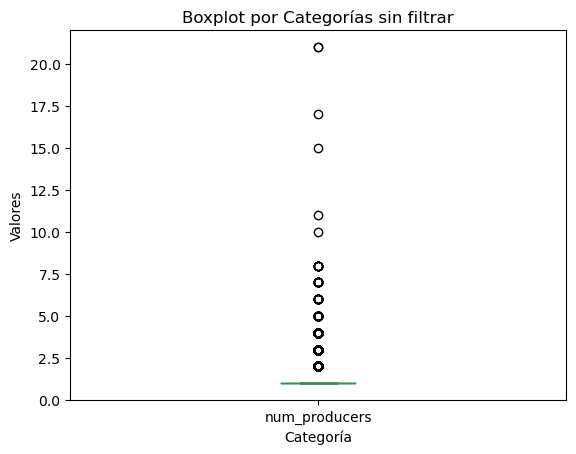

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

df['num_producers'] = df['producers'].apply(lambda x: len(str(x).split(',')))


df.boxplot(column="num_producers", grid=False)

plt.title("Boxplot por Categorías sin filtrar")
plt.suptitle("")  
plt.xlabel("Categoría")
plt.ylabel("Valores")
plt.show()

#### Datos filtrados: 

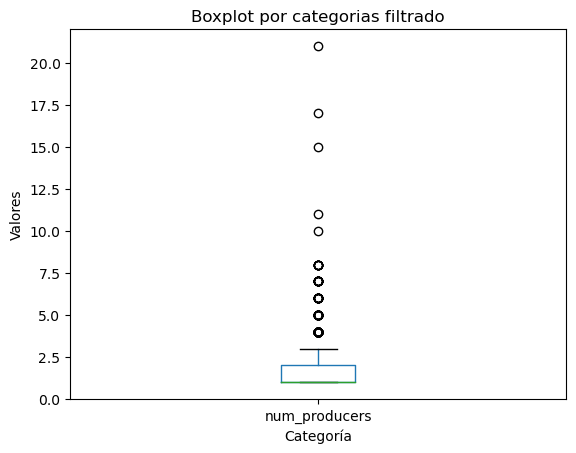

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filtrado['num_producers'] = df_filtrado['producers'].apply(lambda x: len(str(x).split(',')))


df_filtrado.boxplot(column="num_producers", grid=False)

plt.title("Boxplot por categorias filtrado")
plt.suptitle("")  
plt.xlabel("Categoría")
plt.ylabel("Valores")
plt.show()

Debido a la disminución de canciones en el dataset filtrado, los cuartiles aumentaron, así como se redujeron "los outliers". La mediana parece ser igual o parecida en ambos datasets. 

De igual manera se puede hacer con respecto a la longitud de las letras


#### Datos no filtrados: 

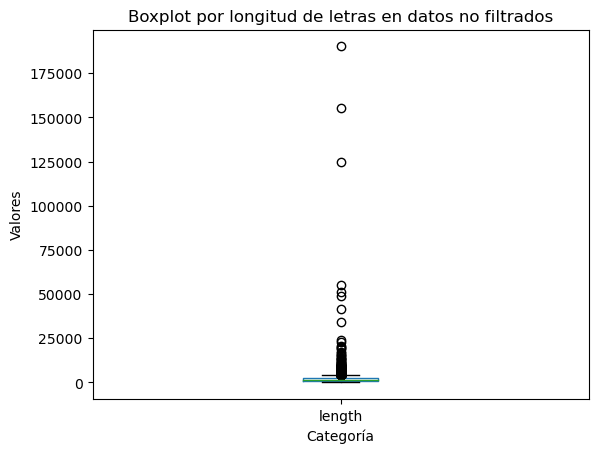

In [174]:
df.boxplot(column="length", grid=False)


plt.title("Boxplot por longitud de letras en datos no filtrados")
plt.suptitle("")  
plt.xlabel("Categoría")
plt.ylabel("Valores")
plt.show()

#### Datos filtrados: 

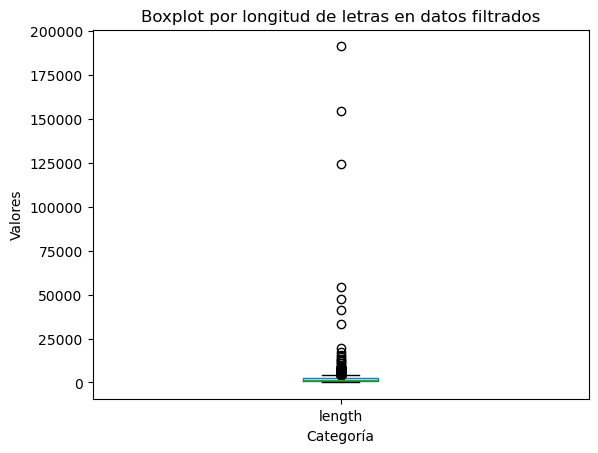

In [175]:
df_filtrado.boxplot(column="length", grid=False)


plt.title("Boxplot por longitud de letras en datos filtrados")
plt.suptitle("")  
plt.xlabel("Categoría")
plt.ylabel("Valores")
plt.show()

Con respecto a la longitud de las letras, estas parecen estar similares o significativamente parecidas. 

## Gráfica de barras o barplot

Un barplot (gráfico de barras) es una representación visual que utiliza barras para comparar diferentes categorías o grupos de datos de forma clara y efectiva. La longitud o altura de las barras es proporcional al valor que representan, lo que permite observar rápidamente diferencias y patrones.

#### Para datos no filtrados: 

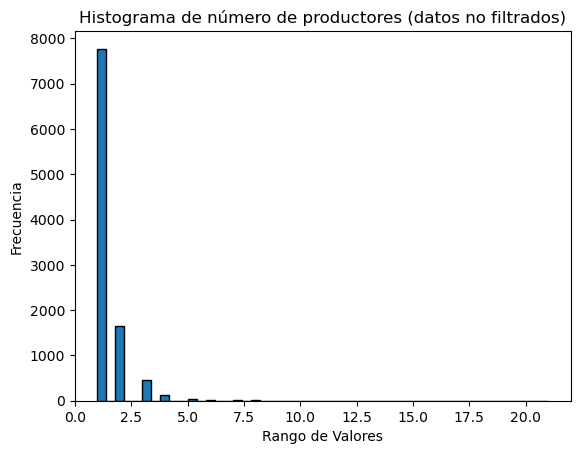

In [176]:
df['num_producers'].plot.hist(bins=50,edgecolor = "black")

plt.title("Histograma de número de productores (datos no filtrados)")
plt.xlabel("Rango de Valores")
plt.ylabel("Frecuencia")

plt.show()


#### Datos filtrados: 

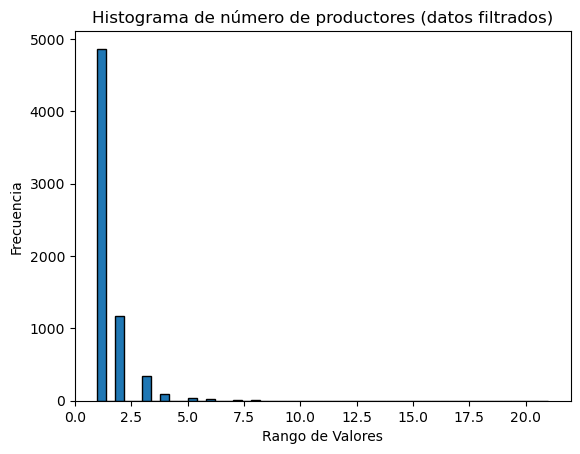

In [177]:
df_filtrado['num_producers'].plot.hist(bins=50,edgecolor = "black")

plt.title("Histograma de número de productores (datos filtrados)")
plt.xlabel("Rango de Valores")
plt.ylabel("Frecuencia")

plt.show()


La forma de ambas gráficas parecen ser las mismas, sin embargo la distribución de frecuencia es menor en el dataset filtrado. 

# Comparación de valores de distribución sobre categorías

__Seaborn__ es una biblioteca de visualización de datos basada en Matplotlib que proporciona una interfaz de alto nivel para crear gráficos estadísticos de manera sencilla y con estilos preconfigurados. Está diseñada para trabajar de manera efectiva con estructuras de datos como DataFrames de pandas, lo que facilita la exploración y representación visual de datos en proyectos de análisis.

## isin

El método `isin` en pandas se utiliza para filtrar filas en un `DataFrame` o `Series` que contienen valores específicos de una lista, conjunto u otro iterable. Es especialmente útil para realizar búsquedas rápidas o verificaciones de pertenencia en un conjunto de datos.

El método `catplot` en Seaborn se utiliza para crear gráficos categóricos, lo que permite visualizar datos categóricos y sus relaciones con variables numéricas o categóricas adicionales. Es altamente versátil y puede generar varios tipos de gráficos categóricos, como gráficos de barras, gráficos de puntos, gráficos de cajas, etc.

Se puede realizar para detectar las palabras 'love' y 'drug' en el nombre de canciones y verificar los datos estadísticos de los nomnres de las canciones filtradas con el número de productores.

#### Canciones no filtradas: 

c:\Users\bugy1\anaconda3\envs\regex\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


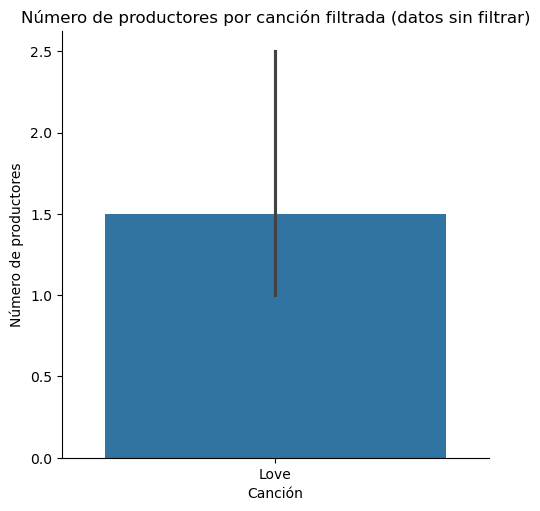

In [178]:
palabras_deseadas = ['Love','Drug']
filtro = df[df["song_name"].isin(palabras_deseadas)]

sns.catplot(data=filtro, x="song_name", y="num_producers", kind="bar")
plt.xlabel("Canción")
plt.ylabel("Número de productores")
plt.title("Número de productores por canción filtrada (datos sin filtrar)")
plt.show()


Variación con gráfico de violín. 

c:\Users\bugy1\anaconda3\envs\regex\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


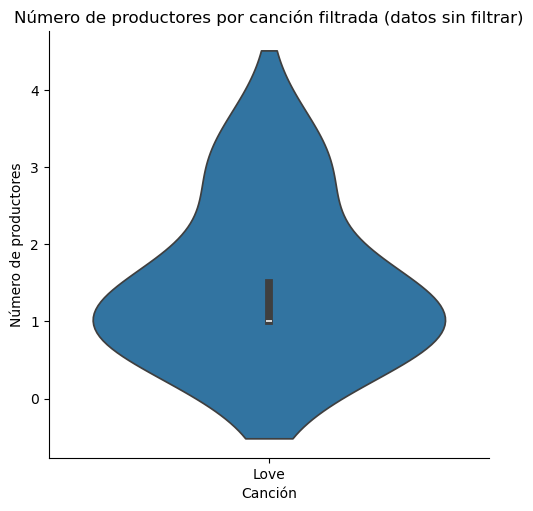

In [179]:
sns.catplot(data=filtro, x="song_name",y= "num_producers", kind="violin")
plt.xlabel("Canción")
plt.ylabel("Número de productores")
plt.title("Número de productores por canción filtrada (datos sin filtrar)")
plt.show()

#### Canciones filtradas: 

c:\Users\bugy1\anaconda3\envs\regex\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


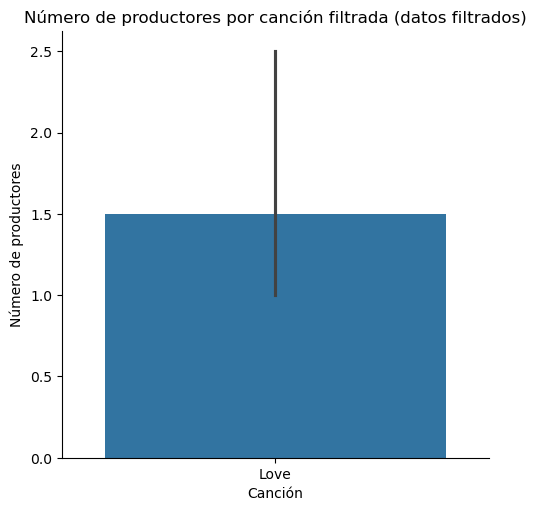

In [180]:
filtro_f = df_filtrado[df_filtrado["song_name"].isin(palabras_deseadas)]

sns.catplot(data=filtro_f, x="song_name", y="num_producers", kind="bar")
plt.xlabel("Canción")
plt.ylabel("Número de productores")
plt.title("Número de productores por canción filtrada (datos filtrados)")
plt.show()


Variación con gráfico de violin. 

c:\Users\bugy1\anaconda3\envs\regex\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


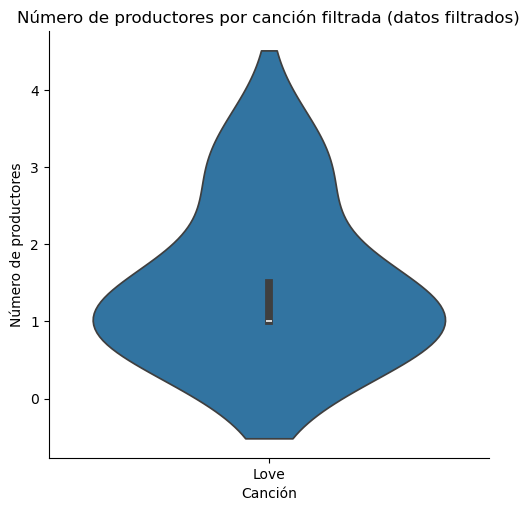

In [181]:
sns.catplot(data=filtro_f, x="song_name",y= "num_producers", kind="violin")
plt.xlabel("Canción")
plt.ylabel("Número de productores")
plt.title("Número de productores por canción filtrada (datos filtrados)")
plt.show()

En estas visualizaciones, la palabra 'love' presenta una distribución similar en los nombres de las canciones, lo cual se debe a que el filtro aplicado a las canciones sí incluye los idiomas seleccionados.

# Visualización de desarrollo sobre el tiempo 

En algunos casos, alguna de las columnas (características) de nuestro conjunto de datos, permitirá un análisis en un periodo de tiempo. En nuestro caso columna `year` permite realizar una visualización del desarrollo de las longitudes de los discursos cada año. 

Para este análisis, utilizaremos el método `groupby` del dataframe permite grupar y realizar operaciones agregadas sobre datos. Es decir, permite dividir un conjunto de datos en grupos basados en valores de una o más columnas y luego aplicar funciones como suma, promedio, conteo, etc., a cada grupo.

#### Datos sin filtrar: 

In [182]:
df['year'] = df['release_date'].str.extract(r'(\d{4})')

resultado_groupby = df.groupby('year').size().reset_index(name='cantidad_canciones')
print(resultado_groupby.head(100))

    year  cantidad_canciones
0   0001                   2
1   1894                   2
2   1897                   1
3   1900                   1
4   1901                   1
..   ...                 ...
77  2021                 734
78  2022                 794
79  2023                 932
80  2024                1346
81  2025                 745

[82 rows x 2 columns]


Agrupando canciones por artista y longitud promedio de canciones (caracteres):  

In [183]:
canciones_por_artista = df.groupby('artist_name')['song_name'].count()
print("Número de canciones por artista:\n", canciones_por_artista)

longitud_prom_por_cancion = df.groupby('song_name')['length'].mean()
print("\n\nLongitud promedio de las letras por canciones: \n",longitud_prom_por_cancion)

Número de canciones por artista:
 artist_name
#LVLUP GRIME CLASH     1
#LikeMe Cast           1
$kyhook                1
$neep                  1
$tupid Young           1
                      ..
花冷え。(HANABIE.)         1
蔡依林 (Jolin Tsai)       1
薛之谦 (Joker Xue)        1
许佳琪 (Xu JiaQi)         1
郑润泽 (Zheng Run Ze)    19
Name: song_name, Length: 2429, dtype: int64


Longitud promedio de las letras por canciones: 
 song_name
#1 Hit Song                         167.0
#4BarFriday                        2417.0
#AYFKM (Freestyle)                 1851.0
#ETHEREALSHAWTY                    1641.0
#Frenchmen - Saison 1 - Nusky      1611.0
                                    ...  
환상동화 (Secret Story of the Swan)    1786.0
회전목마 (MERRY-GO-ROUND)              1383.0
︎i of the storm                    1795.0
󠁪obvio..                           1379.0
󠁪solo un nombre                    1572.0
Name: length, Length: 9780, dtype: float64


Graficando numero de canciones por artista: 

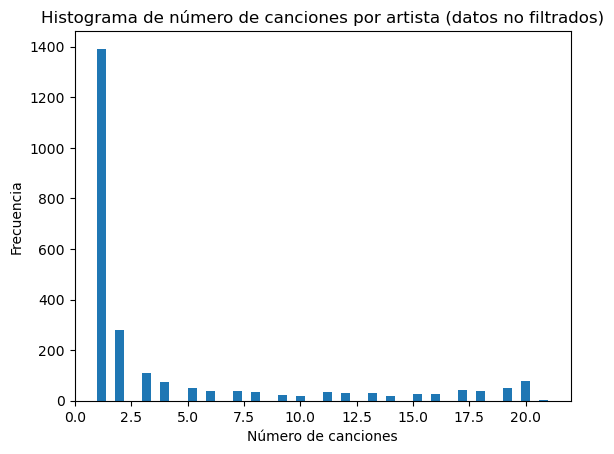

In [184]:
import matplotlib.pyplot as plt

canciones_por_artista.plot.hist(bins=50)
plt.xlabel("Número de canciones")
plt.ylabel("Frecuencia")
plt.title("Histograma de número de canciones por artista (datos no filtrados)")
plt.show()

Graficando longitud promedio por canción: 

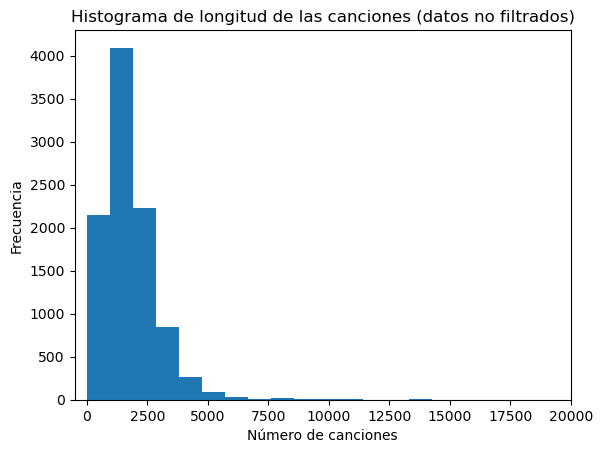

In [185]:
import matplotlib.pyplot as plt

longitud_prom_por_cancion.plot.hist(bins=200)
plt.xlabel("Número de canciones")
plt.ylabel("Frecuencia")
plt.title("Histograma de longitud de las canciones (datos no filtrados)")
plt.xlim(-500,20000)
plt.show()

#### Datos filtrados: 

In [186]:
df_filtrado['year'] = df_filtrado['release_date'].str.extract(r'(\d{4})')

resultado_groupby_f = df_filtrado.groupby('year').size().reset_index(name='cantidad_canciones')
print(resultado_groupby_f.head(100))

    year  cantidad_canciones
0   0001                   1
1   1894                   2
2   1897                   1
3   1900                   1
4   1901                   1
..   ...                 ...
76  2021                 449
77  2022                 484
78  2023                 585
79  2024                 739
80  2025                 407

[81 rows x 2 columns]


In [187]:
canciones_por_artista_f = df_filtrado.groupby('artist_name')['song_name'].count()
print("Número de canciones por artista:\n", canciones_por_artista_f)

longitud_prom_por_cancion_f = df_filtrado.groupby('song_name')['length'].mean()
print("\n\nLongitud promedio de las letras por canciones: \n",longitud_prom_por_cancion_f)

Número de canciones por artista:
 artist_name
$tupid Young                         1
$uicideboy$                          1
015B                                 2
031choppa & Qwellers                 1
03osc                                1
                                    ..
梅林太郎 (Taro Umebayashi)               5
楊丞琳 (Rainie Yang)                    1
王心凌 (Cyndi Wang), 张远 (Zhang Yuan)    1
羽多野渉 (Wataru Hatano)                 2
许佳琪 (Xu JiaQi)                       1
Name: song_name, Length: 1694, dtype: int64


Longitud promedio de las letras por canciones: 
 song_name
#1 Hit Song                       133.0
#4BarFriday                      2318.0
#AYFKM (Freestyle)               1785.0
#Frenchmen - Saison 1 - Nusky    1554.0
#ROFL                            2292.0
                                  ...  
하루 (Leave)                        664.0
해적왕 (Pirate King)                1445.0
︎i of the storm                  1635.0
󠁪obvio..                         1175.0
󠁪solo un nombre     

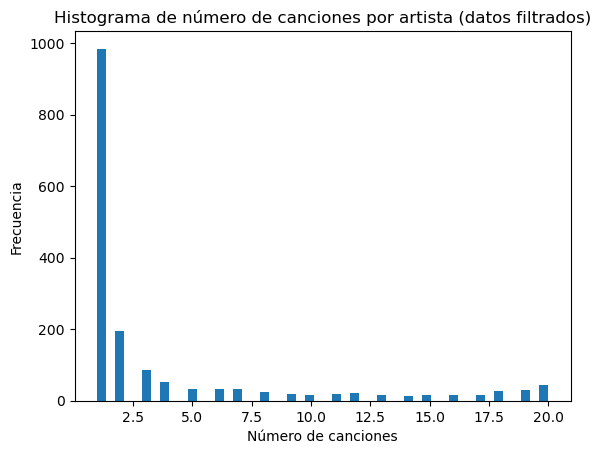

In [188]:
import matplotlib.pyplot as plt

canciones_por_artista_f.plot.hist(bins=50)
plt.xlabel("Número de canciones")
plt.ylabel("Frecuencia")
plt.title("Histograma de número de canciones por artista (datos filtrados)")
plt.show()

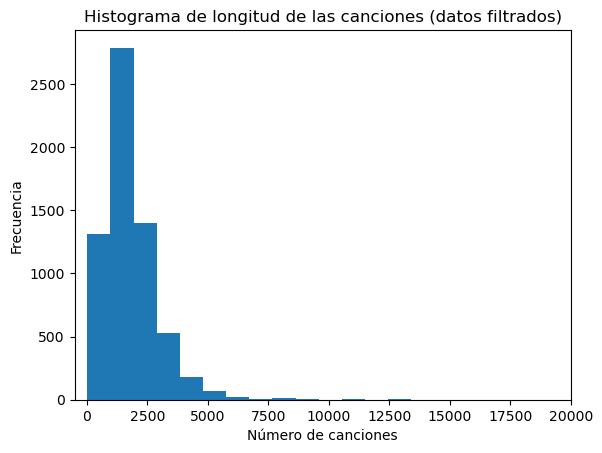

In [189]:
import matplotlib.pyplot as plt

longitud_prom_por_cancion_f.plot.hist(bins=200)
plt.xlabel("Número de canciones")
plt.ylabel("Frecuencia")
plt.title("Histograma de longitud de las canciones (datos filtrados)")
plt.xlim(-500,20000)
plt.show()

Al igual que los análisis anteriores, las distribuciones son iguales, sin embargo la diferencia radica en la frecuencia ya que existe una disminución de canciones con respecto al dataset original

## Conclusión 
De manera general, este proyecto logró la representación visual comparativa de un dataset tras aplicarle un proceso de filtrado. El análisis realizado mostró diferencias notables al hacer énfasis en datos normalizados con datos brutos. Un ejemplo de esto es cómo la frecuencia de una palabra en el dataset puede variar considerablemente al remover duplicados, influyendo en las estadísticas descriptivas.